# Phenome-Wide analysis on COPDgene data: python PIC-SURE API use-case

This notebook is an illustration example of how to use the python **PIC-SURE API** to select and query data from an HPDS-hosted database. It takes as use-case a simple PheWAS analysis. This notebook is intentionally straightforward, without too much explanation. For a more step-by-step introduction to the python PIC-SURE API, see the `PICSURE-API_101_PheWAS_example.ipynb` Notebook.

**Before running this notebook, please be sure to get an user-specific security token. For more information on how to proceed, see the `HPDS_connection.ipynb` notebook**

# Environment set-up

### System requirements
- python 3.6 or later
- pip & bash interpreter

### Installation of external dependencies

In [1]:
!pip install -r requirements.txt

  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-bsu_yygr
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-bsu_yygr
  Cloning https://github.com/hms-dbmi/pic-sure-python-client.git to /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-t5i6zjc1
  Running command git clone -q https://github.com/hms-dbmi/pic-sure-python-client.git /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-req-build-t5i6zjc1
  Created wheel for PicSureHpdsLib: filename=PicSureHpdsLib-0.9.0-py2.py3-none-any.whl size=17132 sha256=3f00727c36c325d714d382aed482eda40a598f0fa4afac4859c1420ffc26f0b2
  Stored in directory: /private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/pip-ephem-wheel-cache-miml989s/wheels/6c/ac/12/4d142709d83e0bdd96c661e183f2dcbb0e03f90e98e5ac256e
  Created wh

In [2]:
import json
from pprint import pprint

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

import PicSureHpdsLib
import PicSureClient

from python_lib.utils import get_multiIndex_variablesTable, get_dic_renaming_vars, match_dummies_to_varNames, joining_variablesTable_onCol
from python_lib.HPDS_connection_manager import tokenManager

In [3]:
print("NB: This Jupyter Notebook has been written using PIC-SURE API following versions:\n- PicSureHpdsLib: 1.1.0\n- PicSureClient: 0.1.0")
print("The PIC-SURE API libraries versions you've been downloading are:\n- PicSureHpdsLib: {0}\n- PicSureClient: {1}".format(PicSureHpdsLib.__version__, PicSureClient.__version__))

NB: This Jupyter Notebook has been written using PIC-SURE API following versions:
- PicSureHpdsLib: 1.1.0
- PicSureClient: 0.1.0
The PIC-SURE API libraries versions you've been downloading are:
- PicSureHpdsLib: 1.1.0
- PicSureClient: 0.1.0


In [4]:
# Pandas DataFrame display options
pd.set_option("max.rows", 435)

# Matplotlib display parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
font = {'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

## Connecting to a PIC-SURE network

In [5]:
PICSURE_network_URL = "https://copdgene-dev.hms.harvard.edu/picsure/"
COPDGene_resource = "b6ef7b1a-56f6-11e9-8958-0242c0a83007"
token_file = "tokens/copd.txt"

In [6]:
token = tokenManager(token_file).get_token()


Security Token Imported Correctly


In [7]:
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, token, allowSelfSignedSSL=True)
adapter = PicSureHpdsLib.Adapter(connection)
resource = adapter.useResource(COPDGene_resource)

## PheWAS analysis

In a nutshell, this PheWAS analysis consists of two main steps:
- Running univariate tests again every phenotypes variable
- Adjusting for multiple testing issue

In this example, we will select every phenotype variables available in the Dictionary, except for the variables pertaining to the "Sub-study ESP LungGO COPDGene" category (very small and specific population as compared to the COPDGene one).

## PheWAS analysis

In a nutshell, this PheWAS analysis follows those subsequent steps:
- Retrieving the variables dictionary, using the PIC-SURE API dedicated methods
- From the info provided by the dictionary, retrieving the data in an exploitable format through PIC-SURE API calls
- Data management
- Running univariate tests again every phenotypes variable
- Adjusting for multiple testing issue
- Plotting the results


This analysis is conducted using COPDGene Study data. The study overall goal is to detect underlying genetic factors to develop Chronic Obstructive Pulmonary Disease (COPD), and enrolled more than 10,000 individuals ([more information on COPDGene Study](http://www.copdgene.org)).

### 1. Retrieving variable dictionary from HPDS Database

Requesting only COPDGene related variables

In [8]:
plain_variablesDict = resource.dictionary().find().DataFrame()

In [9]:
variablesDict = get_multiIndex_variablesTable(plain_variablesDict)

### 2. Selecting variables and retrieving data from HPDS

In [10]:
mask_pheno = variablesDict["HpdsDataType"] == "phenotypes"
mask_substudy = variablesDict.index.get_level_values(0) != "Sub-study ESP LungGO COPDGene"
mask_vars = mask_pheno & mask_substudy
selected_vars = variablesDict.loc[mask_vars, "varName"].tolist()

In [11]:
query = resource.query()
query.select().add(selected_vars)
facts = query.getResultsDataFrame(selected_vars).set_index("Patient ID")

/Users/Arnaud/miniconda3/envs/dbmi_jupyterhub/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


We just check that our query runned the way intended by looking at the number of rows and columns

In [12]:
facts.head(5)

,\00 Affection status\,\00 Consent groups\,\01 Demographics\Age at enrollment\,\01 Demographics\Gender\,\01 Demographics\Other\De-identified site code\,"\01 Demographics\Other\Year of visit, to use for longitudinal analysis\",\01 Demographics\Race\,\01 Demographics\Your ethnic background\,\02 Medical history\Exclusionary disease\Other primary disease so subject excluded from COPD disease analysis such as ILD or Bronchiectasis\,\02 Medical history\Medical history form\01 Health status\,...,\03 Clinical data\Spirometry\02 Postbronchodilator Pulmonary Function Testing\FVC post-bronch\,\03 Clinical data\Spirometry\02 Postbronchodilator Pulmonary Function Testing\PEF post-bronch\,\03 Clinical data\Spirometry\03 Pre Postbronchodilator\Pre Post-bronch FEV1 percent change\,\03 Clinical data\Spirometry\03 Pre Postbronchodilator\Pre Post-bronch FEV1 volume change\,\03 Clinical data\Spirometry\03 Pre Postbronchodilator\Pre Post-bronch FVC percent change\,\03 Clinical data\Spirometry\03 Pre Postbronchodilator\Pre Post-bronch FVC volume change\,\03 Clinical data\Spirometry\04 Other\ATS ERS classification\,\03 Clinical data\Spirometry\04 Other\Bronchodilator responsiveness\,\03 Clinical data\Spirometry\04 Other\Flag for low TLC percent predicted (lower than 70 percent)\,"\03 Clinical data\Spirometry\04 Other\New Gold Classification, using SGRQ for QOL\"
Patient ID,,,,,,,,,,,,,,,,,,,,,
431794,Other,COPD_HMB,46.1,Female,C16,2008.0,African American,Not Hispanic or Latino,NaN,Fair,...,3.995,4.796,31.6,0.547,16.5,0.565,Poss normal variant,1.0,Not flagged as an issue,B
431795,Control,COPD_HMB,59.0,Male,C08,2009.0,Caucasian,Not Hispanic or Latino,NaN,Very Good,...,3.991,10.205,-0.9,-0.024,4.5,0.171,Normal,0.0,Not flagged as an issue,A
431796,Control,COPD_HMB,55.7,Male,C13,2009.0,African American,Not Hispanic or Latino,NaN,Good,...,4.010,8.985,-4.2,-0.150,-5.5,-0.234,Normal,0.0,Not flagged as an issue,A
431797,Control,COPD_HMB,62.1,Female,C21,2008.0,Caucasian,Not Hispanic or Latino,NaN,Excellent,...,3.232,6.398,7.5,0.186,5.0,0.155,Normal,0.0,Not flagged as an issue,A
431798,Case,COPD_HMB,55.2,Female,C04,2008.0,Caucasian,Not Hispanic or Latino,NaN,Fair,...,2.393,2.174,4.3,0.027,6.3,0.141,Very severe,0.0,Not flagged as an issue,D1


In [13]:
print("{0} rows, {1} columns".format(*facts.shape))

10371 rows, 328 columns


### 3. Data-management

#### Selecting variables regarding their types

One important step in a PheWAS is to get the distinction between categorical and numerical variables. This distinction is straightforward using the variables dictionary.

In [14]:
mask_categories = variablesDict.loc[mask_vars, "categorical"] == True
categorical_varnames = variablesDict.loc[mask_vars,:].loc[mask_categories, "varName"].tolist()
continuous_varnames = variablesDict.loc[mask_vars,:].loc[~mask_categories, "varName"].tolist()

### Selecting the dependent variable to study
Most of PheWAS use a genetic variant as the variable used to separate the population between cases and controls. However the population doesn't have to be dichotomized using a genetic variant, and any phenotypic variable could be used to run a PheWAS analysis (see for example [*Neuraz et al.*, 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003405)). 

Here we will use the **COPD status** as the case-control variable to dichotomize the population in our analysis (ie the dependent variable for which univariate association test will be run against).

In [15]:
dependent_var_name = variablesDict.loc[variablesDict["simplified_varName"] == "00 Affection status", "varName"].values[0]
categorical_varnames.remove(dependent_var_name)

Then we subset our population regarding the relevant values for the COPD diagnosis variable (i.e. keeping "Case" and "Control" individuals, thus discarding "Other", "Control, Exclusionary Disease", and null values).

In [16]:
mask_dependent_var_name = facts[dependent_var_name].isin(["Case", "Control"])
facts = facts.loc[mask_dependent_var_name,:]
print("Control: {0} individuals\nCase: {1} individuals".format(*facts[dependent_var_name].value_counts().tolist()))

Control: 4499 individuals
Case: 3692 individuals


Next we create dummy variables in order to be able to carry categorical univariate statistical tests, and we store their names in the dictionary alongside corresponding original variables in the dictionary.

In [17]:
facts_dummies = pd.get_dummies(facts, columns=categorical_varnames, drop_first=True)

In [18]:
matching_dummies_varNames = match_dummies_to_varNames(facts.columns,
                                                      facts_dummies.columns,
                                                      columns=["varName", "dummies_varName"])

In [19]:
variablesDict = joining_variablesTable_onCol(variablesDict,
                                              matching_dummies_varNames,
                                              left_col="varName",
                                              right_col="varName",
                                              overwrite=False)

In [20]:
variablesDict.head()

varName  \
level_0             level_1           level_2                 level_3 level_4                                                    
00 Affection status NaN               NaN                     NaN     NaN                                \00 Affection status\   
00 Consent groups   NaN               NaN                     NaN     NaN                                  \00 Consent groups\   
01 Demographics     Age at enrollment NaN                     NaN     NaN                  \01 Demographics\Age at enrollment\   
                    Gender            NaN                     NaN     NaN                             \01 Demographics\Gender\   
                    Other             De-identified site code NaN     NaN      \01 Demographics\Other\De-identified site code\   

                                                                                    simplified_varName  \
level_0             level_1           level_2                 level_3 level_4                            
00 Affection status NaN               NaN                     NaN     NaN          00 Affection status   
00 Consent groups   NaN               NaN                     NaN     NaN            00 Consent groups   
01 Demographics     Age at enrollment NaN                     NaN     NaN            Age at enrollment   
                    Gender            NaN                     NaN     NaN                       Gender   
                    Other             De-identified site code NaN     NaN      De-identified site code   

                                                                               observationCount  \
level_0             level_1           level_2                 level_3 level_4                     
00 Affection status NaN               NaN                     NaN     NaN                 10371   
00 Consent groups   NaN               NaN                     NaN     NaN                 10371   
01 Demographics     Age at enrollment NaN                     NaN     NaN                 10371   
                    Gender            NaN                     NaN     NaN                 10371   
                    Other             De-identified site code NaN     NaN                 10371   

                                                                               categorical  \
level_0             level_1           level_2                 level_3 level_4                
00 Affection status NaN               NaN                     NaN     NaN             True   
00 Consent groups   NaN               NaN                     NaN     NaN             True   
01 Demographics     Age at enrollment NaN                     NaN     NaN            False   
                    Gender            NaN                     NaN     NaN             True   
                    Other             De-identified site code NaN     NaN             True   

                                                                                                                  categoryValues  \
level_0             level_1           level_2                 level_3 level_4                                                      
00 Affection status NaN               NaN                     NaN     NaN           [Case, Control, Exclusionary Disease, Other]   
00 Consent groups   NaN               NaN                     NaN     NaN                              [COPD_DS-CS-RD, COPD_HMB]   
01 Demographics     Age at enrollment NaN                     NaN     NaN                                                   None   
                    Gender            NaN                     NaN     NaN                                         [Female, Male]   
                    Other             De-identified site code NaN     NaN      [C01, C02, C03, C04, C05, C06, C07, C08, C09, ...   

                                                                                min  \
level_0             level_1           level_2                 level_3 level_4         
00 Affection 

### 4. Univariate statistical tests

To this point, each variable present in the facts_dummies dataset will be tested again the selected dependent variable, (ie presence or absence of COPD). 

Two different association test will be carried out according to variables data types: 
- Mann-Whitney U test for continuous ones
- Fisher exact test for categorical ones

#### Numerical variables: Mann-Whitney U test

In [21]:
grouped = facts_dummies.groupby(dependent_var_name) 

dic_mannwhitneyu = {}
for var in continuous_varnames: 
    group1, group2 = [group[1].dropna() for group in grouped[var]]
    try:
        dic_mannwhitneyu[var] = stats.mannwhitneyu(group1, group2).pvalue
    except ValueError:
        dic_mannwhitneyu[var] = np.NaN

#### Qualitative variables: Fisher Exact test

In [22]:
dummy_categorical_varnames = variablesDict.loc[variablesDict["varName"].isin(categorical_varnames),:]\
["dummies_varName"].values[:500]

In [23]:
# Fisher test for categorical variables
from tqdm import tqdm
dic_fisher = {}
try:
    for var in tqdm(dummy_categorical_varnames, position=0, leave=True):
        if type(var) != str:
            print("skipping {0}".format(var))
            continue
        elif var not in facts_dummies.columns:
            print("skipping {0}, not in dataframe columns".format(var))
            continue        
        crosstab = pd.crosstab(facts_dummies[var], facts_dummies[dependent_var_name])
        if crosstab.shape == (1,2):
            dic_fisher[var] = np.NaN
        else:
            dic_fisher[var] = stats.fisher_exact(crosstab)[1]
except AttributeError:
    print("End of loop tqdm AttributeError catched")

 10%|█         | 28/279 [00:03<00:30,  8.31it/s]

skipping nan
skipping nan


 18%|█▊        | 51/279 [00:03<00:10, 21.07it/s]

skipping nan


 25%|██▌       | 71/279 [00:05<00:09, 22.80it/s]

skipping nan


 51%|█████▏    | 143/279 [00:12<00:05, 23.15it/s]

skipping nan
skipping nan


 59%|█████▉    | 165/279 [00:13<00:07, 15.23it/s]

skipping nan


 61%|██████▏   | 171/279 [00:14<00:09, 11.66it/s]

skipping nan


 62%|██████▏   | 173/279 [00:14<00:14,  7.24it/s]

skipping nan


 64%|██████▍   | 178/279 [00:15<00:15,  6.61it/s]

skipping nan


 65%|██████▌   | 182/279 [00:15<00:13,  6.96it/s]

skipping nan


 69%|██████▉   | 192/279 [00:16<00:09,  9.06it/s]

skipping nan


100%|██████████| 279/279 [00:28<00:00,  9.94it/s]


#### Univariate test p-values distribution

Text(0.5, 0.98, 'Distribution of individual p-values for Mann-Whintey U test')

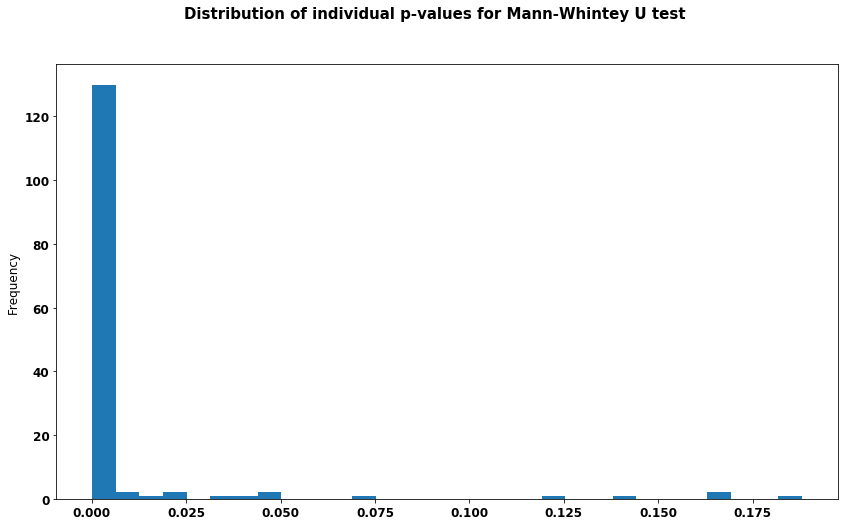

In [24]:
pd.Series([v for v in dic_mannwhitneyu.values()]).plot.hist(bins=30)
plt.suptitle("Distribution of individual p-values for Mann-Whintey U test",
             weight="bold",
            fontsize=15)

Text(0.5, 0.98, 'Distribution of individual p-values for Fisher association test')

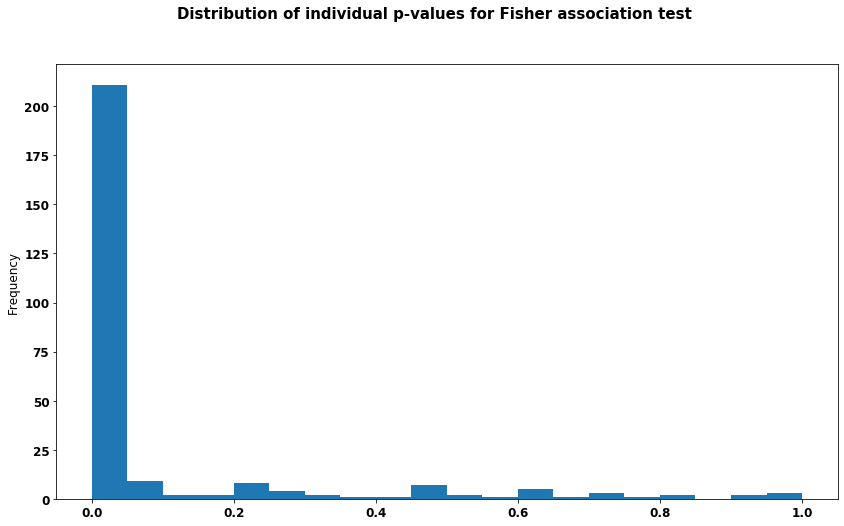

In [25]:
pd.Series([v for v in dic_fisher.values()]).plot.hist(bins=20)
plt.suptitle("Distribution of individual p-values for Fisher association test", 
             size=30,
             weight="bold",
            fontsize=15)

### 5. Multiple hypotheses testing correction: Bonferroni Method

In order to handle the multiple comparison issue (increase in the probability to "discover" false statistical associations, because of the number of tests performed), we will use the Bonferroni correction method. Although many other multiple comparison exist, Bonferroni is the most straightforward to use, because it doesn't require assumptions about variables correlation. Other PheWAS analysis also use False Discovery Rate controlling procedures ([see](https://en.wikipedia.org/wiki/False_discovery_rate)).

In a nutshell, Bonferonni allows to calculate a corrected "statistical significant threshold" according to the number of test performed. Every p-value below this threshold will be deemed statistically significant.

In [26]:
# Merging pvalues from different tests
dic_pvalues = {**dic_mannwhitneyu, **dic_fisher}
df_pvalues = pd.DataFrame.from_dict(dic_pvalues, orient="index", columns=["pvalues"])\
.rename_axis("dummies_varName")\
.reset_index(drop=False)

# Adding pvalues results as a new column to variablesDict
variablesDict = joining_variablesTable_onCol(variablesDict,
                                              df_pvalues,
                                              left_col="dummies_varName",
                                              right_col="dummies_varName")

In [27]:
adjusted_alpha = 0.05/len(variablesDict["pvalues"])
variablesDict["p_adj"] = variablesDict["pvalues"] / len(variablesDict["pvalues"])

In [28]:
variablesDict['log_p'] = -np.log10(variablesDict['pvalues'])

/Users/Arnaud/miniconda3/envs/dbmi_jupyterhub/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
pd.set_option('expand_frame_repr', False)

In [30]:
variablesDict = variablesDict.sort_index()
variablesDict["group"] = variablesDict.reset_index(level=1)["level_1"].values

## 6. Result visualisations: Manhattan plot

Manhattan plot is the classical results representation of a PheWAS analysis. It plots every each tested phenotypical variables on the X-axis, against its *-log(pvalue)* on the Y-axis. The horizontal line represent the adjusted significance level threshold.

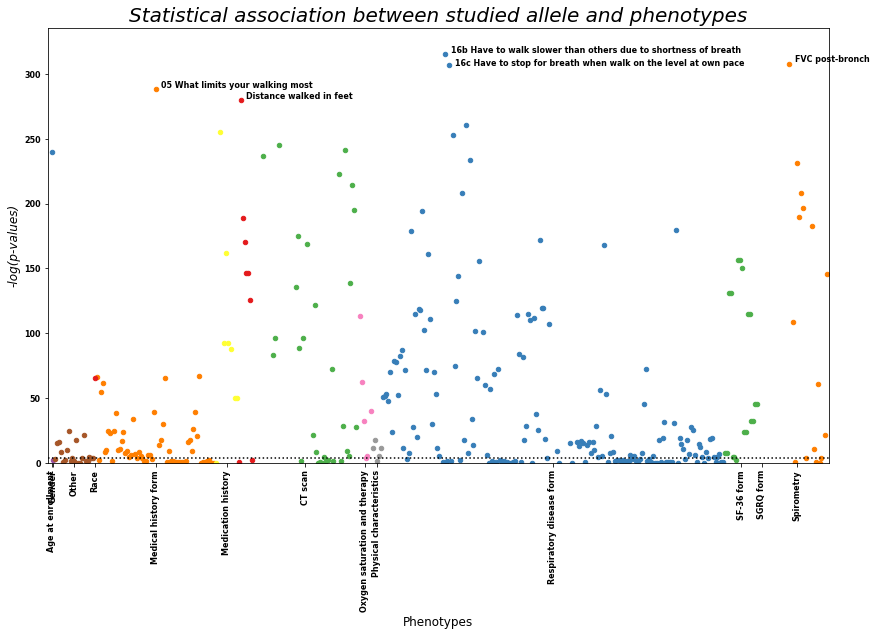

In [31]:
mask = variablesDict["pvalues"].isna()
df_results = variablesDict.loc[~mask,:].copy().replace([np.inf, -np.inf], np.nan)
df_results["ind"] = np.arange(1, len(df_results)+1)
df_grouped = df_results.groupby(('group'))

# print(df_grouped.head(10))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = plt.get_cmap('Set1')
x_labels = []
x_labels_pos = []

y_lims = (0,
          df_results["log_p"].max(skipna=True) + 20)
threshold_top_values = df_results["log_p"].sort_values(ascending=False)[0:6][-1]

for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='log_p',color=colors.colors[num % len(colors.colors)], ax=ax, s=20)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2)) # Set label in the middle
        
        pair_ind = 0 # To shift label which might overlap because to close
        for n, row in group.iterrows():
            if pair_ind %2 == 0:
                shift = 1.1
            else:
                shift = -1.1
            if row["log_p"] > threshold_top_values:
                ax.text(row['ind'] + 3, row["log_p"] + 0.05 + shift, row["simplified_varName"], rotation=0, alpha=1, size=8, color="black")
                pair_ind += 1
                
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df_results) +1])
ax.set_ylim(y_lims)
ax.set_ylabel('-log(p-values)', style="italic")
ax.set_xlabel('Phenotypes')
ax.axhline(y=-np.log10(adjusted_alpha), linestyle=":", color="black")
plt.xticks(fontsize = 8,rotation=90)
plt.yticks(fontsize = 8)
plt.title("Statistical association between studied allele and phenotypes", 
          loc="center",
          style="oblique", 
          fontsize = 20,
         y=1)
xticks = ax.xaxis.get_major_ticks()
xticks[0].set_visible(False)

plt.show()

Overall, it appears that most of the tested phenotypes covariates are above the adjusted threshold of significant association. However, it is not surprising at all, given the nature of our dependent variable: a lot of those variables are by nature tied directly to the COPD status.

This code can be used directly with any other variable present in the variable Dictionary. It only need to change the `dependent_var_name` value.